# How to build an AMBER-compatible host-guest complex using the SMIRNOFF force field starting with SYBYL-formatted `mol2` files

In [3]:
import parmed as pmd
import subprocess as sp
import numpy as np

from openeye import oechem
from openforcefield.typing.engines.smirnoff import *
from pdbfixer import PDBFixer

## Step 0: generate SYBYL-formatted `mol2` files

Starting with files containing AM1-BCC charges and GAFF v1.7 Lennard-Jones and bonded parameters:

```
antechamber -i cb7.mol2 -fi mol2 -o cb7-sybyl.mol2 -fo mol2 -at sybyl
antechamber -i ben.mol2 -fi mol2 -o ben-sybyl.mol2 -fo mol2 -at sybyl -dr n 
# Disable `acdoctor` to handle carboxylate group
```

In [15]:
path = './cb7-guest1/'
cb7 = path + 'cb7-sybyl.mol2'
guest = path + 'guest-1-sybyl.mol2'

## Step 1: load molecules in an `oechem.OEMol`

In [16]:
mols = []
ifs = oechem.oemolistream(cb7)
for mol in ifs.GetOEGraphMols():
    mols.append(oechem.OEMol(mol))

## Step 1.5: since `bcd` is a cyclic molecule, let's write a version without connectivity and then have OpenEye perceive connectivity based on [this issue](https://github.com/openforcefield/openforcefield/issues/66)

In [17]:
ofs = oechem.oemolostream()
ofs.open(path + 'cb7-no-conect.xyz')
flavor = oechem.OEOFlavor_Generic_Default
ofs.SetFlavor(oechem.OEFormat_XYZ, flavor)
oechem.OEWriteXYZFile(ofs, mols[0])
ofs.close()

In [18]:
ifs = oechem.oemolistream(path + 'cb7-no-conect.xyz')
for mol in ifs.GetOEGraphMols():
    oechem.OEDetermineConnectivity(mol)
    oechem.OEPerceiveBondOrders(mol)
    # Replace existing cyclodextrin
    oechem.OETriposAtomNames(mol)
    mols[0] = oechem.OEMol(mol)

In [19]:
ifs = oechem.oemolistream(ben)
for mol in ifs.GetOEGraphMols():
    mols.append(oechem.OEMol(mol))

## Step 2: build reference molecules for water and ions

In [20]:
smiles = ['[Na+]', '[Cl-]', 'O']
for molecule in smiles:
    mol = oechem.OEMol()
    oechem.OESmilesToMol(mol, molecule)
    for atom in mol.GetAtoms():
        atom.SetPartialCharge(atom.GetFormalCharge())
    oechem.OEAddExplicitHydrogens(mol)
    oechem.OETriposAtomNames(mol)
    mols.append(mol)

## Step 3: read in fully solvated system with host, guest, water, and ions

In [21]:
pdb_with_conect = 'complex.pdb'
pdb = PDBFixer(path + pdb_with_conect)

## Step 4: create a ParmEd structure

In [22]:
ff = ForceField('forcefield/smirnoff99Frosst.ffxml', 'forcefield/tip3p.ffxml') 
system = ff.createSystem(pdb.topology, 
                         mols)
integrator = openmm.VerletIntegrator(1.0 * unit.femtoseconds)
context = openmm.Context(system, integrator)
context.setPositions(pdb.positions)

Exception: No provided molecule matches topology molecule:
Atom        0    N1     0 MOL
Atom        1    C1     0 MOL
Atom        2    C2     0 MOL
Atom        3    C3     0 MOL
Atom        4    C4     0 MOL
Atom        5    C5     0 MOL
Atom        6    C6     0 MOL
Atom        7    C7     0 MOL
Atom        8    C8     0 MOL
Atom        9    C9     0 MOL
Atom       10   C10     0 MOL
Atom       11   C11     0 MOL
Atom       12   C12     0 MOL
Atom       13    H1     0 MOL
Atom       14    H2     0 MOL
Atom       15    H3     0 MOL
Atom       16    H4     0 MOL
Atom       17    H5     0 MOL
Atom       18    H6     0 MOL
Atom       19    H7     0 MOL
Atom       20    H8     0 MOL
Atom       21    H9     0 MOL
Atom       22   H10     0 MOL
Atom       23   H11     0 MOL
Atom       24   H12     0 MOL
Atom       25   H13     0 MOL
Atom       26   H14     0 MOL
Atom       27   H15     0 MOL
Atom       28   H16     0 MOL
Atom       29   H17     0 MOL
Atom       30   H18     0 MOL
Atom       31   H19     0 MOL
Atom       32   H20     0 MOL
Atom       33   H21     0 MOL
Atom       34   H22     0 MOL


## Step 5: save the ParmEd structure as a `.prmtop` file

In [132]:
structure = pmd.openmm.topsystem.load_topology(pdb.topology, system, pdb.positions)

In [133]:
structure.save(path + 'bcd-ben-smirnoff.prmtop')

AttributeError: 'NoneType' object has no attribute 'used'

# Investigate whether the cyclodextrin `OEMol` is correct

In [ ]:
bcd = mols[0]

In [ ]:
from openeye.oedepict import *
OEPrepareDepiction(bcd)

In [ ]:
OERenderMolecule(path + "bcd.png", bcd)
from IPython.display import Image
Image(path + "bcd.png")

This seems okay.

In [62]:
structure.atoms

AtomList([
	<Atom C1 [0]; In MGO 0>
	<Atom H1 [1]; In MGO 0>
	<Atom O1 [2]; In MGO 0>
	<Atom C2 [3]; In MGO 0>
	<Atom H2 [4]; In MGO 0>
	<Atom O2 [5]; In MGO 0>
	<Atom HO2 [6]; In MGO 0>
	<Atom C3 [7]; In MGO 0>
	<Atom H3 [8]; In MGO 0>
	<Atom O3 [9]; In MGO 0>
	<Atom HO3 [10]; In MGO 0>
	<Atom C4 [11]; In MGO 0>
	<Atom H4 [12]; In MGO 0>
	<Atom C5 [13]; In MGO 0>
	<Atom H5 [14]; In MGO 0>
	<Atom O5 [15]; In MGO 0>
	<Atom C6 [16]; In MGO 0>
	<Atom H61 [17]; In MGO 0>
	<Atom H62 [18]; In MGO 0>
	<Atom O6 [19]; In MGO 0>
	<Atom HO6 [20]; In MGO 0>
	<Atom C1 [21]; In MGO 1>
	<Atom H1 [22]; In MGO 1>
	<Atom O1 [23]; In MGO 1>
	...
	<Atom H1 [6799]; In HOH 2229>
	<Atom H2 [6800]; In HOH 2229>
	<Atom O [6801]; In HOH 2230>
	<Atom H1 [6802]; In HOH 2230>
	<Atom H2 [6803]; In HOH 2230>
])

In [63]:
structure.bond_types

TrackedList([
	<BondType; k=340.000, req=1.090>
	<BondType; k=320.000, req=1.370>
	<BondType; k=310.000, req=1.526>
	<BondType; k=320.000, req=1.410>
	<BondType; k=553.000, req=0.960>
	<BondType; k=469.000, req=1.400>
	<BondType; k=367.000, req=1.080>
	<BondType; k=410.000, req=1.450>
	<BondType; k=656.000, req=1.250>
])

In [64]:
structure.bonds

TrackedList([
	<Bond <Atom H1 [175]; In HOH 21>--<Atom O [174]; In HOH 21>; type=None>
	<Bond <Atom H2 [176]; In HOH 21>--<Atom O [174]; In HOH 21>; type=None>
	<Bond <Atom H1 [178]; In HOH 22>--<Atom O [177]; In HOH 22>; type=None>
	<Bond <Atom H2 [179]; In HOH 22>--<Atom O [177]; In HOH 22>; type=None>
	<Bond <Atom H1 [181]; In HOH 23>--<Atom O [180]; In HOH 23>; type=None>
	<Bond <Atom H2 [182]; In HOH 23>--<Atom O [180]; In HOH 23>; type=None>
	<Bond <Atom H1 [184]; In HOH 24>--<Atom O [183]; In HOH 24>; type=None>
	<Bond <Atom H2 [185]; In HOH 24>--<Atom O [183]; In HOH 24>; type=None>
	<Bond <Atom H1 [187]; In HOH 25>--<Atom O [186]; In HOH 25>; type=None>
	<Bond <Atom H2 [188]; In HOH 25>--<Atom O [186]; In HOH 25>; type=None>
	<Bond <Atom H1 [190]; In HOH 26>--<Atom O [189]; In HOH 26>; type=None>
	<Bond <Atom H2 [191]; In HOH 26>--<Atom O [189]; In HOH 26>; type=None>
	<Bond <Atom H1 [193]; In HOH 27>--<Atom O [192]; In HOH 27>; type=None>
	<Bond <Atom H2 [194]; In HOH 27>--<A

In [68]:
bonds = structure.bonds

In [80]:
atoms = structure.atoms

In [90]:
for atom in atoms:
    if len(atom.bond_partners) == 0:
        print(atom, atom.bond_partners)
    if atom.bond_partners is None:
        print(atom, atom.bond_partners)

<Atom Na+ [161]; In Na+ 8> []
<Atom Na+ [162]; In Na+ 9> []
<Atom Na+ [163]; In Na+ 10> []
<Atom Na+ [164]; In Na+ 11> []
<Atom Na+ [165]; In Na+ 12> []
<Atom Na+ [166]; In Na+ 13> []
<Atom Na+ [167]; In Na+ 14> []
<Atom Cl- [168]; In Cl- 15> []
<Atom Cl- [169]; In Cl- 16> []
<Atom Cl- [170]; In Cl- 17> []
<Atom Cl- [171]; In Cl- 18> []
<Atom Cl- [172]; In Cl- 19> []
<Atom Cl- [173]; In Cl- 20> []


In [95]:
pmd.__version__

'2.7.3'

In [96]:
openmm.__version__

'7.1.1'

In [97]:
openeye.__version__

'2017.Jun.1'

# Can I build the host from SMILES?
https://pubchem.ncbi.nlm.nih.gov/compound/beta-CYCLODEXTRIN#section=Top

In [98]:
bcd_smiles = 'C([C@@H]1[C@@H]2[C@@H]([C@H]([C@H](O1)O[C@@H]3[C@H](O[C@@H]([C@@H]([C@H]3O)O)O[C@@H]4[C@H](O[C@@H]([C@@H]([C@H]4O)O)O[C@@H]5[C@H](O[C@@H]([C@@H]([C@H]5O)O)O[C@@H]6[C@H](O[C@@H]([C@@H]([C@H]6O)O)O[C@@H]7[C@H](O[C@@H]([C@@H]([C@H]7O)O)O[C@@H]8[C@H](O[C@H](O2)[C@@H]([C@H]8O)O)CO)CO)CO)CO)CO)CO)O)O)O'

In [100]:
mol = oechem.OEMol()
oechem.OESmilesToMol(mol, bcd_smiles)
for atom in mol.GetAtoms():
    atom.SetPartialCharge(atom.GetFormalCharge())
oechem.OEAddExplicitHydrogens(mol)
oechem.OETriposAtomNames(mol)
# mols.append(mol)

In [101]:
mol

<oechem.OEMol; proxy of <Swig Object of type 'OEMolWrapper *' at 0x7f16fc3deab0> >

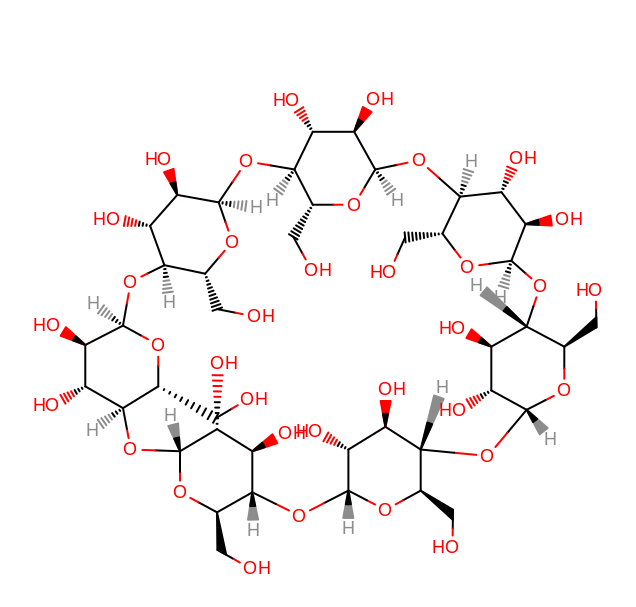

In [104]:
OEPrepareDepiction(mol)
OERenderMolecule(path + "bcd-from-smiles.png", mol)
from IPython.display import Image
Image(path + "bcd-from-smiles.png")

In [109]:
pdb.topology.bonds

<bound method Topology.bonds of <Topology; 2225 chains, 2231 residues, 6804 atoms, 4588 bonds>>